# Esame Data Science - a.a. 2022/2023 - Gianluca Scuri

2. [Classificazione](#esercizio2)
3. [Rete Neurale Custom](#esercizio3)

Partendo dal dataset precedentemente analizzato e ripulito, in questa parte d'esercizio vi viene richiesto di eseguire una clasificazione del dataset.

L'ultima colonna (**Attributo 21**) contiene la label che il modello deve imparare ad apprendere.

Viene richiesto di utilizzare diversi modelli di clusterizzazione, praparare i dati e le feature per il loro utilizzo e quindi effettuare la previsione. Viene chiesto di valutare la bontà della previsione del modello e di commentare la sua capacità di apprendimento.

Avendo utilizzato diversi modelli, viene inoltre richiesto di confrontare i risultati dei diversi modelli utilizzati e di commentare quale sia, a vostro giudizio, il modello preferibile.

In [1]:
# Utils
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Classificatori
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Bilanciamento
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Sklearn utils
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score

# Neural networks
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, ReLU

# Random State
RANDOM_STATE = 42

### Caricamento dei dati

Creati i dizionari che contengono la descrizione degli attributi e dei diversi livelli

In [2]:
# Dictionary of the attributes
attributes_description = {
    1:'Stato del conto corrente esistente',
    2:'Durata in mesi',
    3:'Storia del credito',
    4:'Scopo della richiesta di credito',
    5:'Ammontare del credito',
    6:'Conto di risparmio/obbligazioni',
    7:'Occupazione attuale',
    8:'Tasso di rata in percentuale del reddito disponibile',
    9:'Stato personale e sesso',
    10:'Altri debitori/garanti',
    11:'Attuale residenza da allora',
    12:'Proprietà',
    13:'Età in anni',
    14:'Altri piani di rateizzazione',
    15:'Abitazione',
    16:'Numero di crediti esistenti presso questa banca',
    17:'Lavoro',
    18:'Numero di persone tenute a provvedere al mantenimento',
    19:'Telefono',
    20:'lavoratore straniero',
    21:'Classificazione del credito'
    }

In [3]:
# Dictionary of the levels of the attributes
levels_description = {
    1: {
        'A11': '... < 0 DM',
        'A12': '0 <= ... < 200 DM',
        'A13': '... >= 200 DM / assegnazioni di stipendio per almeno 1 anno',
        'A14': 'nessun conto corrente'
    },
    3: {
        'A30': 'nessun credito preso/tutti i crediti rimborsati debitamente',
        'A31': 'tutti i crediti presso questa banca rimborsati debitamente',
        'A32': 'crediti esistenti regolarmente rimborsati fino ad ora',
        'A33': 'ritardo nel pagamento in passato',
        'A34': 'conto critico/ altri crediti esistenti (non presso questa banca)'
    },
    4: {
        'A40': 'auto (nuova)',
        'A41': 'auto (usata)',
        'A42': 'mobili/attrezzature',
        'A43': 'radio/televisione',
        'A44': 'elettrodomestici',
        'A45': 'riparazioni',
        'A46': 'educazione',
        'A47': '(vacanze - non esiste?)',
        'A48': 'riqualificazione',
        'A49': 'affari',
        'A410': 'altri'
    },
    6: {
        'R61': '... < 100 Marchi',
        'A62': '100 <= ... < 500 DM',
        'A63': '500 <= ... < 1000 DM',
        'A64': '.. >= 1000 DM',
        'A65': 'sconosciuto/ nessun conto di risparmio'
    },
    7: {
        'A71': 'disoccupato',
        'R72': '... < 1 anno',
        'A73': '1 <= ... < 4 anni',
        'A74': '4 <= ... < 7 anni',
        'A75': '.. >= 7 anni'
    },
    9: {
        'A91': 'maschio : divorziato/separato',
        'A92': 'femmina : divorziata/separata/sposata',
        'A93': 'maschio : singolo',
        'A94': 'maschio : sposato/vedovo',
        'A95': 'femmina : single'
    },
    10: {
        'A101': 'nessuno',
        'A102': 'co-candidato',
        'A103': 'garante'
    },
    12: {
        'A121': 'immobiliare',
        'A122': 'se non A121 : contratto di risparmio della società di costruzione/assicurazione sulla vita',
        'A123': 'se non A121/A122 : automobile o altro, non nell\'attributo 6',
        'A124': 'sconosciuto / nessuna proprietà'
    },
    14: {
        'A141': 'banca',
        'A142': 'negozi',
        'A143': 'nessuno'
    },
    15: {
        'A151': 'affitto',
        'A152': 'proprio',
        'A153': 'gratis'
    },
    17: {
        'A171': 'disoccupato/non qualificato - non residente',
        'A172': 'non qualificato - residente',
        'A173': 'impiegato/funzionario qualificato',
        'A174': 'dirigente/ lavoratore autonomo/ impiegato/funzionario altamente qualificato'
    },
    19: {
        'A191': 'nessuno',
        'A192': 'sì, registrato a nome del cliente'
    },
    20: {
        'A201': 'sì',
        'A202': 'no'
    },
    21: {
        1: 'buono',
        2: 'cattivo'
    }
}

In [4]:
# Load dataset
data = pd.read_csv("data/german.data", sep=" ", header=None) # Rename columns to match the dataset description

data.columns = data.columns + 1

data = data.astype({ # Convert columns type
    1: 'category',
    2: int,
    3: 'category',
    4: 'category',
    5: int,
    6: 'category',
    7: 'category',
    8: int,
    9: 'category',
    10: 'category',
    11: int,
    12: 'category',
    13: int,
    14: 'category',
    15: 'category',
    16: int,
    17: 'category',
    18: int,
    19: 'category',
    20: 'category',
    21: 'category'
    })

data.head()

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### Ingegneria delle features

In questa sezione vengono preparati gli attributi e la varaibile target per la classificazione.

#### One-hot encoding

Il primo passaggio prevede la trasformazione delle variabili categoriche in variabili dummy, per ogni n livelli vengono create n-1 variabili dummy. Per nessun degli attributi categorici possono essere utilizzati attributi ordinali.

In [5]:
data.columns = data.columns.astype(str)

# Creazione dataset per classificazione
X = data.drop('21', axis=1)
X = pd.get_dummies(X, columns=X.select_dtypes(include='category').columns, drop_first=True)

y = data['21']
y = y.map({1:0, 2:1}) # 0 = buono, 1 = cattivo

In [6]:
X.head()

,2,5,8,11,13,16,18,1_A12,1_A13,1_A14,...,12_A124,14_A142,14_A143,15_A152,15_A153,17_A172,17_A173,17_A174,19_A192,20_A202
0,6,1169,4,4,67,2,1,False,False,False,...,False,False,True,True,False,False,True,False,True,False
1,48,5951,2,2,22,1,1,True,False,False,...,False,False,True,True,False,False,True,False,False,False
2,12,2096,2,3,49,1,2,False,False,True,...,False,False,True,True,False,True,False,False,False,False
3,42,7882,2,4,45,1,2,False,False,False,...,False,False,True,False,True,False,True,False,False,False
4,24,4870,3,4,53,2,2,False,False,False,...,True,False,True,False,True,False,True,False,False,False


In [7]:
y.head()

0    0
1    1
2    0
3    0
4    1
Name: 21, dtype: category
Categories (2, int64): [0, 1]

#### Split train e test

Il secondo passo prevede la divisione del dataset in una partizione per l'addestramento e una per la verifica delle performance. La proporzione dello split é 90% e 10%.

In [8]:
# Split 90% training - 10% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=RANDOM_STATE, stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 48), (900,), (100, 48), (100,))

#### Standardizzazione

Un passaggio importante é la standardizzazione degli attributi in input per evitare che quelli con valori assoluti maggiori vengano pesati maggiormente.
Viene quindi applicato StandardScaler() ai soli dati di training. Ai dati di test viene poi applicata la trasformazione appresa sulla porzione di training.

In [9]:
# Standardizzare i dati z = (x - u) / s
scaler = StandardScaler()
X_train_stand = pd.DataFrame(scaler.fit_transform(X_train),
                            index=X_train.index,
                            columns=X_train.columns)
X_test_stand = pd.DataFrame(scaler.transform(X_test),
                            index=X_test.index,
                            columns=X_test.columns)
X_train_stand.head()

,2,5,8,11,13,16,18,1_A12,1_A13,1_A14,...,12_A124,14_A142,14_A143,15_A152,15_A153,17_A172,17_A173,17_A174,19_A192,20_A202
230,1.294714,0.348735,0.935745,-0.778087,-0.838199,-0.711151,-0.432822,-0.609878,3.919647,-0.797724,...,-0.421913,-0.221249,0.475561,0.635654,-0.341504,-0.498263,0.760886,-0.414578,-0.833616,-0.204124
507,-0.481957,1.298843,-1.723741,-0.778087,-0.129279,-0.711151,2.310417,1.639672,-0.255125,-0.797724,...,-0.421913,-0.221249,0.475561,0.635654,-0.341504,-0.498263,-1.314257,2.412091,1.199593,-0.204124
585,-0.228147,-0.432585,-1.723741,1.036105,-1.369889,-0.711151,-0.432822,-0.609878,-0.255125,-0.797724,...,-0.421913,-0.221249,-2.102781,-1.573183,-0.341504,-0.498263,0.760886,-0.414578,-0.833616,-0.204124
241,-1.243387,-0.592376,0.049250,-0.778087,1.377175,-0.711151,2.310417,-0.609878,-0.255125,1.253566,...,-0.421913,-0.221249,0.475561,0.635654,-0.341504,-0.498263,0.760886,-0.414578,-0.833616,-0.204124
350,-0.989577,-0.721576,-1.723741,1.036105,-1.104044,-0.711151,-0.432822,-0.609878,-0.255125,1.253566,...,-0.421913,-0.221249,0.475561,-1.573183,-0.341504,-0.498263,0.760886,-0.414578,1.199593,-0.204124


#### Bilanciamento classi

Come si é visto nella fase di esplorazione sono presenti piú records per quanto riguarda la classificazione del credito buono rispetto a cattivo. Questo é un problema poiché se non corretto in fase di training il modello puó tendere a classificare piú falsi negativi, molto pericolosi in questo ambito specifico.

Text(0, 0.5, '')

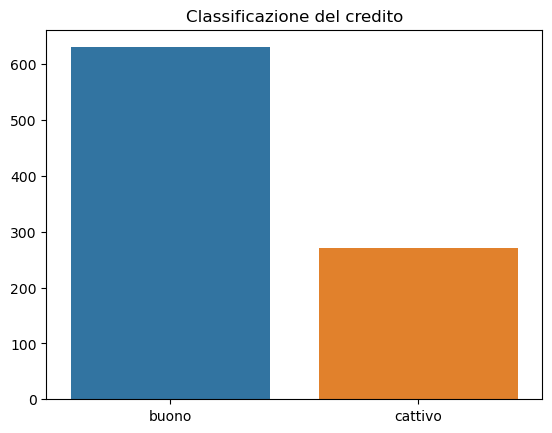

In [10]:
# Plot distribuzione variabile target
sns.barplot(x=['buono', 'cattivo'], y=y_train.value_counts()).set_title(attributes_description[21])
plt.ylabel('')

In [11]:
# Non bilanciato
print('buono:\t\t', y_train.value_counts()[0],
      '\ncattivo:\t', y_train.value_counts()[1])

buono:		 630 
cattivo:	 270


Per il bilanciamento del dataset viene utilizzato il metodo SMOTE, una delle più popolari tecniche di oversampling.

In [12]:
# Bilanciato
sm = SMOTE(random_state=RANDOM_STATE)
X_train_stand_bal, y_train_bal = sm.fit_resample(X_train_stand, y_train)

print('buono:\t\t', y_train_bal.value_counts()[0],
      '\ncattivo:\t', y_train_bal.value_counts()[1])

buono:		 630 
cattivo:	 630


#### Riduzione della dimensionalitá

Nel caso di dataset con molti attributi la PCA e altri metodi di riduzione della dimensionalità hanno tre usi principali: <br>
1) Ridurre la dimensionalità e quindi la complessità del tuo set di dati; <br>
2) Pre-elaborare i dati in preparazione per altri compiti di apprendimento supervisionato, come la regressione e la classificazione; <br>
3) Per facilitare la visualizzazione dei dati.

Di seguito viene valutato quanto la varianza spiegata viene influenzata dal numero di componenti considerate.

In [13]:
var_ratio = []

nums = list(range(0, 49, 5)) + [48]
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(X_train_stand)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

Text(0.5, 1.0, 'Variabilità spiegata per numero di componenti')

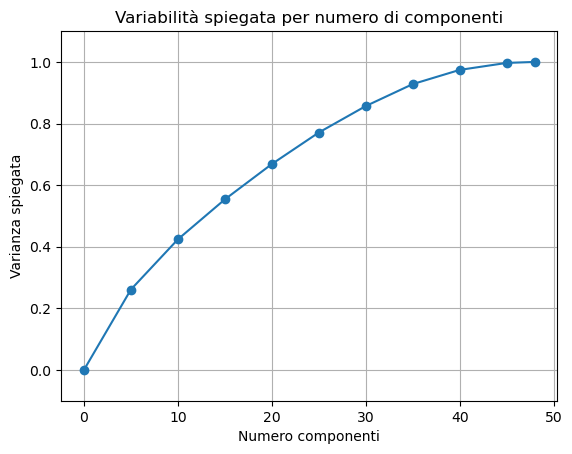

In [14]:
fig, ax = plt.subplots()
plt.grid()

ax.plot(nums,var_ratio,marker='o')
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('Numero componenti')
ax.set_ylabel('Varianza spiegata')
ax.set_title('Variabilità spiegata per numero di componenti')

La percentuale di variabilita spiegata non necessariamente corrisponde alla capacita di classificazione.

<a id="esercizio2"></a>
## Classificazione

In questa sezione vengono testati i principali modelli di machine learning per la classificazione binaria. Per valutare le performance di classificazione si é deciso di eseguire una cross validation dividendo il training set in 5 partizioni per ottenere valori piú affidabili delle metriche.
Per avere risultati affidabili le procedure di standardizzazione, bilanciamento e pca vengono applicati di volta in volta alle solo partizioni di trining e non di validation. Questo é reso possibilie attraverso l'utilizzo di pipeline.

Vista la natura del problema, in cui la classificazione errata di un cattivo creditore puó portare a perdite economiche anche importanti, la scelta del modello viene fatta in funzione di massimizzare la recall valutando a paritá di risultati la F1.

#### Confronto modelli

In [15]:
folds = StratifiedKFold(n_splits = 5, random_state = RANDOM_STATE, shuffle=True) # 5-fold cross validation

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'] # metriche da calcolare

classifiers = [('log', LogisticRegression(random_state=RANDOM_STATE)),
               ('svc', SVC(random_state=RANDOM_STATE)),
               ('knn', KNeighborsClassifier()),
               ('gpc', GaussianProcessClassifier()),
               ('dtc', DecisionTreeClassifier(random_state=RANDOM_STATE)),
               ('rfc', RandomForestClassifier(random_state=RANDOM_STATE)),
               ('abc', AdaBoostClassifier()),
               ('gnb', GaussianNB())]

In [16]:
# Funzione per calcolare matrici di confusione
def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1]}

In [17]:
scores = {}
scores_cm = {}

for clf in tqdm(classifiers):

    pipeline = Pipeline([('scaler', StandardScaler()), # standardizzazione,
                         ('smote', SMOTE(random_state=RANDOM_STATE)), # bilanciamento
                        clf]) # classificatore
    
    tmp = cross_validate(pipeline, X_train, y_train, cv = folds, scoring=scoring) # cross validation
    tmp_cm = cross_validate(pipeline, X_train, y_train, cv = folds, scoring=confusion_matrix_scorer) # cross validation
    
    scores[clf[0]] = {k: np.mean(v) for k, v in tmp.items()} # calcolo media delle metriche
    scores_cm[clf[0]] = {k: np.mean(v) for k, v in tmp_cm.items()} # calcolo media delle metriche

scores = pd.DataFrame(scores).T # conversione in dataframe
scores_cm = pd.DataFrame(scores_cm).T # conversione in dataframe

100%|██████████| 8/8 [00:16<00:00,  2.09s/it]


In [18]:
scores.sort_values(by='test_recall', ascending=False) # ordinamento per recall

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
gnb,0.089415,0.012443,0.626667,0.448097,0.755556,0.555128,0.720091
knn,0.086546,0.187410,0.614444,0.420420,0.751852,0.539107,0.704159
log,0.096826,0.014584,0.712222,0.517071,0.666667,0.581686,0.776543
gpc,0.367164,0.048863,0.644444,0.432868,0.585185,0.497391,0.659553
abc,0.204728,0.027593,0.732222,0.555086,0.585185,0.568388,0.773280
svc,0.125581,0.041373,0.736667,0.567568,0.533333,0.549422,0.772693
dtc,0.092127,0.015182,0.692222,0.489103,0.477778,0.482480,0.630952
rfc,0.330641,0.030366,0.726667,0.564544,0.403704,0.469851,0.771781


In [19]:
scores_cm.sort_values(by='test_tp', ascending=False)

,fit_time,score_time,test_tn,test_fp,test_fn,test_tp
gnb,0.086468,0.005509,72.0,54.0,13.2,40.8
knn,0.088614,0.094100,70.0,56.0,13.4,40.6
log,0.100149,0.005123,92.2,33.8,18.0,36.0
gpc,0.360178,0.015029,84.4,41.6,22.4,31.6
abc,0.214560,0.009376,100.2,25.8,22.4,31.6
svc,0.124710,0.017811,103.8,22.2,25.2,28.8
dtc,0.095260,0.004711,98.8,27.2,28.2,25.8
rfc,0.328427,0.013233,109.0,17.0,32.2,21.8


Il modello Gaussian Naive Bayes é quello che presenta il valore di Recall maggiore e anche a livello di F1 presenta valori maggiori. Viene quindi scelto come modello migliore. Di seguito viene valutato se é possibile incrementare ulteriormente i risultati.

In [20]:
# select the best model
best_clf = classifiers[7]

#### Aggiunta PCA

In questa sezione viene valutato se l'aggiunta della PCA puó portare qualche beneficio ed eventualmente qual é il numero ideale di componenti da considerare. Per fare questo viene eseguita una grid search su diversi numeri di componenti.

In [21]:
pipeline = Pipeline([('scaler', StandardScaler()), # standardizzazione
                     ('smote', SMOTE()), # bilanciamento
                     ('pca', PCA()), # riduzione dimensionalità
                     best_clf # classificatore
                    ]) 

param = {'pca__n_components': [5, 10, 20, 30, 40, 48]} # parametri da testare

In [22]:
grid_search = GridSearchCV(pipeline, param_grid=param, cv=folds, scoring='recall',
                               return_train_score=True, verbose=1)

In [23]:
tmp = grid_search.fit(X_train, y_train)

print(tmp.best_params_)
print(tmp.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'pca__n_components': 5}
0.6814814814814815


Il valore che viene indicato come megliore é quello di 5 componenti, questo peró presenta dei valori inferiori di Recall. Per questo motivo di seguito escludiamo l'uso della PCA.

#### Ottimizzazione iperparametri

In questa sezione viene eseguita una grid search sui parametri del modello individuato come migliore. In particolare vengono provati diversi valori del parametro `var_smoothing` che é responsabile di allargare la curva gaussiana andando ad includere valori che si trovano lontani dalla media.

In [24]:
pipeline = Pipeline([('scaler', StandardScaler()), # standardizzazione
                     ('smote', SMOTE()), # bilanciamento
                     best_clf # classificatore
                     ]) 

param = {'gnb__var_smoothing': [0.0000001, 0.00000001, 0.000000001, 0.0000000001]} # parametri da testare

In [25]:
grid_search = GridSearchCV(pipeline, param_grid=param, cv=folds, scoring='recall',
                               return_train_score=True, verbose=1)

In [26]:
tmp = grid_search.fit(X_train, y_train)

print(tmp.best_params_)
print(tmp.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'gnb__var_smoothing': 1e-10}
0.762962962962963


Dalla grid search é emerso che il valore migliore per questo parametro é 1e-09 e permette di aumentare di qualche punto percentuale il valore di recall.

### Valutazione sul test set

In questa sezione il modello individuato come migliore viene applicato alla porzione di dati di test per valutare la capacitá di generalizzazione del modello. Il modello viene quindi riallenato su tutta la partizione di training e non solo su alcune folds.

In [27]:
clf = GaussianNB(var_smoothing=tmp.best_params_['gnb__var_smoothing'])
clf.fit(X_train_stand_bal, y_train_bal)

GaussianNB(var_smoothing=1e-10)

In [28]:
pred = clf.predict(X_test_stand)
print('Recall: ', recall_score(y_test, pred))

Recall:  0.6333333333333333


Il valore di racall é inferiore a quello ottenuto come media sulle 5 partizioni di validation. Di seguito viene riportata la matrice di confusione sul test set.

Text(0.5, 1.0, 'Matrice di confusione test set')

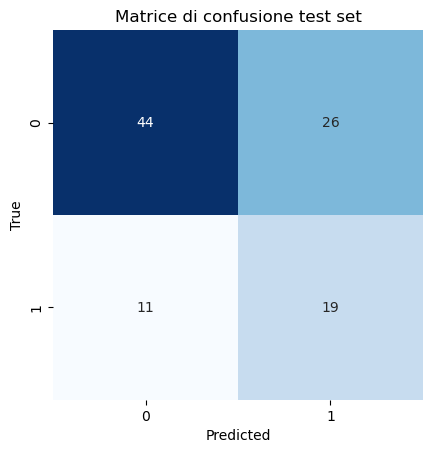

In [29]:
cm_test = confusion_matrix(y_test, pred)

fig, axs = plt.subplots(1,1)
sns.heatmap(cm_test, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', ax=axs)
axs.set_xlabel('Predicted')
axs.set_ylabel('True')
axs.set_title('Matrice di confusione test set')

<a id="esercizio3"></a>
## Rete Neurale Custom

In questa sezione vengono invece valutate le abilitá predittive di un modello basato su rete neurale. 

In [30]:
# Split 90% training - 10% validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train_stand_bal, y_train_bal, test_size = 0.1, random_state=RANDOM_STATE, stratify=y_train_bal)

X_tr.shape, y_tr.shape, X_val.shape, y_val.shape

((1134, 48), (1134,), (126, 48), (126,))

#### Modello minimale

In [31]:
# Definizione del modello
model1 = Sequential()

model1.add(Dense(units=24, input_dim=X_train_stand_bal.shape[1]))
model1.add(ReLU())
model1.add(Dense(units=1, activation='sigmoid'))

In [32]:
# Definizione metriche
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='AUC')
]
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Compilazione e fit del modello
opt = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=METRICS)

history = model1.fit(X_tr, y_tr, epochs=100, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/100
36/36 [==============================] - 1s 15ms/step - loss: 0.7620 - accuracy: 0.5344 - precision: 0.5556 - recall: 0.3439 - AUC: 0.5711 - val_loss: 0.7216 - val_accuracy: 0.6190 - val_precision: 0.6744 - val_recall: 0.4603 - val_AUC: 0.6179
Epoch 2/100
36/36 [==============================] - 0s 2ms/step - loss: 0.6418 - accuracy: 0.6508 - precision: 0.6792 - recall: 0.5714 - AUC: 0.6986 - val_loss: 0.6389 - val_accuracy: 0.6667 - val_precision: 0.6909 - val_recall: 0.6032 - val_AUC: 0.7163
Epoch 3/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5792 - accuracy: 0.7090 - precision: 0.7158 - recall: 0.6931 - AUC: 0.7674 - val_loss: 0.5980 - val_accuracy: 0.7619 - val_precision: 0.7463 - val_recall: 0.7937 - val_AUC: 0.7507
Epoch 4/100
36/36 [==============================] - 0s 3ms/step - loss: 0.5404 - accuracy: 0.7346 - precision: 0.7358 - recall: 0.7319 - AUC: 0.8077 - val_loss: 0.5849 - val_accuracy: 0.7619 - val_precision: 0.7538 - val_recall: 0.77

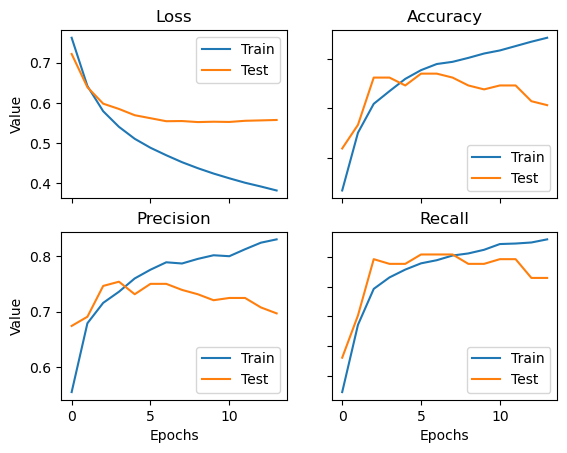

In [33]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(history.history['loss'])
axs[0, 0].plot(history.history['val_loss'])
axs[0, 0].set_title('Loss')
axs[0, 0].legend(['Train','Test'])
###############################################
axs[0, 1].plot(history.history['accuracy'])
axs[0, 1].plot(history.history['val_accuracy'])
axs[0, 1].set_title('Accuracy')
axs[0, 1].legend(['Train','Test'])
###############################################
axs[1, 0].plot(history.history['precision'])
axs[1, 0].plot(history.history['val_precision'])
axs[1, 0].set_title('Precision')
axs[1, 0].legend(['Train','Test'])
###############################################
axs[1, 1].plot(history.history['recall'])
axs[1, 1].plot(history.history['val_recall'])
axs[1, 1].set_title('Recall')
axs[1, 1].legend(['Train','Test'])

for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Value')

# Hide x labels and tick labels for top plots and y ticks for right plots
for ax in axs.flat:
    ax.label_outer()

In [34]:
history.history['val_recall'][-1]

0.7301587462425232

#### Modello piú complesso

In [35]:
# Definizione del modello
model2 = Sequential()

model2.add(Dense(units=24, input_dim=X_train_stand_bal.shape[1]))
model2.add(ReLU())
model2.add(Dense(units=12, input_dim=X_train_stand_bal.shape[1]))
model2.add(ReLU())
model2.add(Dense(units=1, activation='sigmoid'))

In [36]:
# Definizione metriche
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='AUC')
]
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Compilazione e fit del modello
opt = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=METRICS)

history = model2.fit(X_tr, y_tr, epochs=100, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/100
36/36 [==============================] - 1s 14ms/step - loss: 0.7093 - accuracy: 0.5388 - precision: 0.5327 - recall: 0.6314 - AUC: 0.5248 - val_loss: 0.6896 - val_accuracy: 0.5794 - val_precision: 0.5806 - val_recall: 0.5714 - val_AUC: 0.5583
Epoch 2/100
36/36 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6146 - precision: 0.6260 - recall: 0.5697 - AUC: 0.6596 - val_loss: 0.6647 - val_accuracy: 0.5952 - val_precision: 0.6071 - val_recall: 0.5397 - val_AUC: 0.6359
Epoch 3/100
36/36 [==============================] - 0s 3ms/step - loss: 0.6227 - accuracy: 0.6843 - precision: 0.7013 - recall: 0.6420 - AUC: 0.7444 - val_loss: 0.6342 - val_accuracy: 0.6429 - val_precision: 0.6500 - val_recall: 0.6190 - val_AUC: 0.6930
Epoch 4/100
36/36 [==============================] - 0s 3ms/step - loss: 0.5783 - accuracy: 0.7302 - precision: 0.7368 - recall: 0.7160 - AUC: 0.7997 - val_loss: 0.6042 - val_accuracy: 0.6587 - val_precision: 0.6562 - val_recall: 0.66

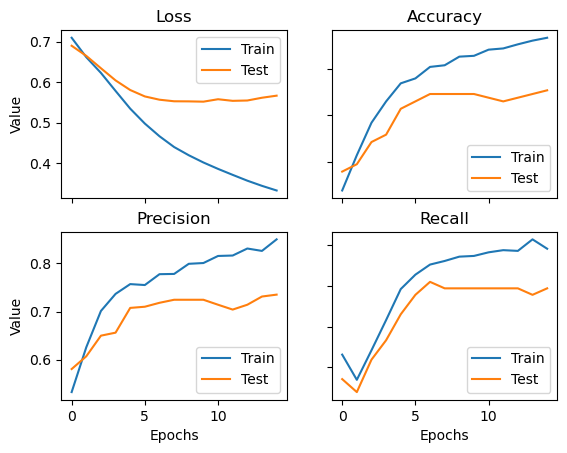

In [37]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(history.history['loss'])
axs[0, 0].plot(history.history['val_loss'])
axs[0, 0].set_title('Loss')
axs[0, 0].legend(['Train','Test'])
###############################################
axs[0, 1].plot(history.history['accuracy'])
axs[0, 1].plot(history.history['val_accuracy'])
axs[0, 1].set_title('Accuracy')
axs[0, 1].legend(['Train','Test'])
###############################################
axs[1, 0].plot(history.history['precision'])
axs[1, 0].plot(history.history['val_precision'])
axs[1, 0].set_title('Precision')
axs[1, 0].legend(['Train','Test'])
###############################################
axs[1, 1].plot(history.history['recall'])
axs[1, 1].plot(history.history['val_recall'])
axs[1, 1].set_title('Recall')
axs[1, 1].legend(['Train','Test'])

for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Value')

# Hide x labels and tick labels for top plots and y ticks for right plots
for ax in axs.flat:
    ax.label_outer()

In [38]:
history.history['val_recall'][-1]

0.7936508059501648

### Valutazione sul test set

#### Modello minimale

In [39]:
pred = model1.predict(X_test_stand)
pred = np.where(pred>0.5, 1, 0).flatten()
print('Recall: ', recall_score(y_test, pred))

4/4 [==============================] - 0s 2ms/step
Recall:  0.7


Questo modello seppur molto semplice presenta una recall sul test set maggiore dei modelli tradizionali di machine learning.

Text(0.5, 1.0, 'Matrice di confusione test set')

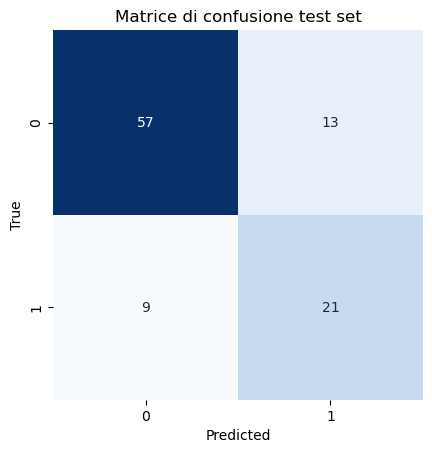

In [40]:
cm_test = confusion_matrix(y_test, pred)

fig, axs = plt.subplots(1,1)
sns.heatmap(cm_test, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', ax=axs)
axs.set_xlabel('Predicted')
axs.set_ylabel('True')
axs.set_title('Matrice di confusione test set')

#### Modello piú complesso

In [41]:
pred = model2.predict(X_test_stand)
pred = np.where(pred>0.5, 1, 0).flatten()
print('Recall: ', recall_score(y_test, pred))

4/4 [==============================] - 0s 0s/step
Recall:  0.6666666666666666


Text(0.5, 1.0, 'Matrice di confusione test set')

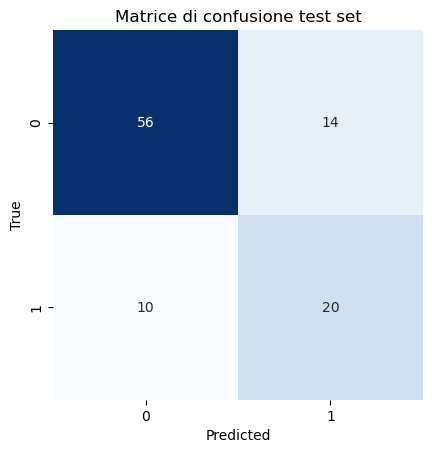

In [42]:
cm_test = confusion_matrix(y_test, pred)

fig, axs = plt.subplots(1,1)
sns.heatmap(cm_test, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', ax=axs)
axs.set_xlabel('Predicted')
axs.set_ylabel('True')
axs.set_title('Matrice di confusione test set')

In conclusione in modello che ha mostrato la migliore capacitá predittiva e di generalizzazione é la rete neurale molto semplice composta da un solo layer hidden. Questa permette di individuare il 70% dei cattivi creditori con una precisione del 62% a differenza del miglior modello di machine learning tradizionale che permette di individure il 63% dei cattivi creditori con una precisione del 42%.